In [1]:
from utils import *
from sklearn import metrics
from sklearn.datasets import make_friedman1, make_friedman2, make_friedman3
import pandas as pd
plt.style.use('default')
plt.rc('font', size=16, family='serif')
plt.rc('mathtext', default='it', fontset='cm')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
datasets = []
datasets_std = []

In [3]:
name = 'Friedman 1'
noise = 1.5

X_train, y_train = make_friedman1(noise=0.0, random_state=18397425)
_, y_train_noisy = make_friedman1(noise=noise, random_state=18397425)
X_norm_train= normalize(X_train, axis=1)

X_test, y_test = make_friedman1(noise=0.0, random_state=30189745)
_, y_test_noisy = make_friedman1(noise=noise, random_state=30189745)
X_norm_test= normalize(X_test, axis=1)

# [X_train, y_train, X_test, y_test, X_draw, norm, noise, name]
datasets.append([X_train, y_train, X_test, y_test, X_test, False, 0.0, name])
datasets.append([X_train, y_train_noisy, X_test, y_test_noisy, X_test, False, noise, name])
datasets.append([X_norm_train, y_train, X_norm_test, y_test, X_test, True, 0.0, name])
datasets.append([X_norm_train, y_train_noisy, X_norm_test, y_test_noisy, X_test, True, noise, name])

print(X_test[0])

X_rescale_train = np.zeros_like(X_train)
X_rescale_test = np.zeros_like(X_test)

for i in range(0, X_rescale_train.shape[1]):
    X_rescale_train[:,i] = (X_train[:,i] - np.mean(X_train[:,i])) / np.std(X_train[:,i])
    X_rescale_test[:,i] = (X_test[:,i] - np.mean(X_test[:,i])) / np.std(X_test[:,i])

print(X_rescale_test[0])

X_norm_rescale_train = normalize(X_rescale_train, axis=1)
X_norm_rescale_test = normalize(X_rescale_test, axis=1)

datasets_std.append([X_rescale_train, y_train, X_rescale_test, y_test, X_test, False, 0.0, name + ' Std'])
datasets_std.append([X_rescale_train, y_train_noisy, X_rescale_test, y_test_noisy, X_test, False, noise, name + ' Std'])
datasets_std.append([X_norm_rescale_train, y_train, X_norm_rescale_test, y_test, X_test, True, 0.0, name + ' Std'])
datasets_std.append([X_norm_rescale_train, y_train_noisy, X_norm_rescale_test, y_test_noisy, X_test, True, noise, name + ' Std'])

[0.14734293 0.96969391 0.7031536  0.59113441 0.28890767 0.99933427
 0.34536703 0.6296617  0.23879122 0.346948  ]
[-1.36630824  1.64229288  0.74995799  0.40723948 -0.83883613  1.78141897
 -0.69289087  0.49638197 -1.00721333 -0.64278257]


In [4]:
name = 'Friedman 2'
noise = 5

X_train, y_train = make_friedman2(noise=0.0, random_state=18397425)
_, y_train_noisy = make_friedman2(noise=noise, random_state=18397425)
X_norm_train= normalize(X_train, axis=1)

X_test, y_test = make_friedman2(noise=0.0, random_state=30189745)
_, y_test_noisy = make_friedman2(noise=noise, random_state=30189745)
X_norm_test= normalize(X_test, axis=1)

# [X_train, y_train, X_test, y_test, X_draw, norm, noise, name]
datasets.append([X_train, y_train, X_test, y_test, X_test, False, 0.0, name])
datasets.append([X_train, y_train_noisy, X_test, y_test_noisy, X_test, False, noise, name])
datasets.append([X_norm_train, y_train, X_norm_test, y_test, X_test, True, 0.0, name])
datasets.append([X_norm_train, y_train_noisy, X_norm_test, y_test_noisy, X_test, True, noise, name])

print(X_test[0])

X_rescale_train = np.zeros_like(X_train)
X_rescale_test = np.zeros_like(X_test)

for i in range(0, X_rescale_train.shape[1]):
    X_rescale_train[:,i] = (X_train[:,i] - np.mean(X_train[:,i])) / np.std(X_train[:,i])
    X_rescale_test[:,i] = (X_test[:,i] - np.mean(X_test[:,i])) / np.std(X_test[:,i])

print(X_rescale_test[0])

X_norm_rescale_train = normalize(X_rescale_train, axis=1)
X_norm_rescale_test = normalize(X_rescale_test, axis=1)

datasets_std.append([X_rescale_train, y_train, X_rescale_test, y_test, X_test, False, 0.0, name + ' Std'])
datasets_std.append([X_rescale_train, y_train_noisy, X_rescale_test, y_test_noisy, X_test, False, noise, name + ' Std'])
datasets_std.append([X_norm_rescale_train, y_train, X_norm_rescale_test, y_test, X_test, True, 0.0, name + ' Std'])
datasets_std.append([X_norm_rescale_train, y_train_noisy, X_norm_rescale_test, y_test_noisy, X_test, True, noise, name + ' Std'])

[1.47342930e+01 1.70978300e+03 7.03153602e-01 6.91134408e+00]
[-1.33488338  1.53372914  0.67076602  0.20857328]


In [5]:
name = 'Friedman 3'
noise = 0.15

X_train, y_train = make_friedman3(noise=0.0, random_state=18397425)
_, y_train_noisy = make_friedman3(noise=noise, random_state=18397425)
X_norm_train= normalize(X_train, axis=1)

X_test, y_test = make_friedman3(noise=0.0, random_state=30189745)
_, y_test_noisy = make_friedman3(noise=noise, random_state=30189745)
X_norm_test= normalize(X_test, axis=1)

# [X_train, y_train, X_test, y_test, X_draw, norm, noise, name]
datasets.append([X_train, y_train, X_test, y_test, X_test, False, 0.0, name])
datasets.append([X_train, y_train_noisy, X_test, y_test_noisy, X_test, False, noise, name])
datasets.append([X_norm_train, y_train, X_norm_test, y_test, X_test, True, 0.0, name])
datasets.append([X_norm_train, y_train_noisy, X_norm_test, y_test_noisy, X_test, True, noise, name])

print(X_test[0])

X_rescale_train = np.zeros_like(X_train)
X_rescale_test = np.zeros_like(X_test)

for i in range(0, X_rescale_train.shape[1]):
    X_rescale_train[:,i] = (X_train[:,i] - np.mean(X_train[:,i])) / np.std(X_train[:,i])
    X_rescale_test[:,i] = (X_test[:,i] - np.mean(X_test[:,i])) / np.std(X_test[:,i])

print(X_rescale_test[0])

X_norm_rescale_train = normalize(X_rescale_train, axis=1)
X_norm_rescale_test = normalize(X_rescale_test, axis=1)

datasets_std.append([X_rescale_train, y_train, X_rescale_test, y_test, X_test, False, 0.0, name + ' Std'])
datasets_std.append([X_rescale_train, y_train_noisy, X_rescale_test, y_test_noisy, X_test, False, noise, name + ' Std'])
datasets_std.append([X_norm_rescale_train, y_train, X_norm_rescale_test, y_test, X_test, True, 0.0, name + ' Std'])
datasets_std.append([X_norm_rescale_train, y_train_noisy, X_norm_rescale_test, y_test_noisy, X_test, True, noise, name + ' Std'])

[1.47342930e+01 1.70978300e+03 7.03153602e-01 6.91134408e+00]
[-1.33488338  1.53372914  0.67076602  0.20857328]


In [6]:
%%capture
depths = (2, 3, 10)
experiment_output = []
for dataset in datasets:
    for depth in depths:
        experiment_output.append(experiment(dataset, depth=depth, log=True))

In [7]:
%%capture
depths = (2, 3, 10)
experiment_output_std = []
for dataset in datasets_std:
    for depth in depths:
        experiment_output_std.append(experiment(dataset, depth=depth, log=True))

In [8]:
all_outputs = {}
all_outputs['norm_y'] = experiment_output
all_outputs['norm_y_rescale'] = experiment_output_std

In [9]:
%%capture
depths = (2, 3, 10)
experiment_output = []
for dataset in datasets:
    for depth in depths:
        experiment_output.append(experiment(dataset, depth=depth, log=True, norm_y=False))

In [10]:
%%capture
depths = (2, 3, 10)
experiment_output_std = []
for dataset in datasets_std:
    for depth in depths:
        experiment_output_std.append(experiment(dataset, depth=depth, log=True, norm_y=False))

In [11]:
all_outputs['none'] = experiment_output
all_outputs['rescale'] = experiment_output_std

In [12]:
print(all_outputs.keys())

dict_keys(['norm_y', 'norm_y_rescale', 'none', 'rescale'])


In [13]:
save_data(all_outputs, 'exp_norm_test_FIXED')

In [ ]:
all_outputs = load_data('./exp_norm_test')

In [14]:
all_outputs['norm_y'][0]['dataset']['test'][0][0], all_outputs['norm_y_rescale'][0]['dataset']['test'][0][0]
# [0.14734293 0.96969391 0.7031536  0.59113441 0.28890767 0.99933427
#  0.34536703 0.6296617  0.23879122 0.346948  ]
# [-1.36630824  1.64229288  0.74995799  0.40723948 -0.83883613  1.78141897
#  -0.69289087  0.49638197 -1.00721333 -0.64278257]

(array([0.14734293, 0.96969391, 0.7031536 , 0.59113441, 0.28890767,
        0.99933427, 0.34536703, 0.6296617 , 0.23879122, 0.346948  ]),
 array([-1.36630824,  1.64229288,  0.74995799,  0.40723948, -0.83883613,
         1.78141897, -0.69289087,  0.49638197, -1.00721333, -0.64278257]))

In [15]:
np.sqrt(np.mean((all_outputs['norm_y'][0]['dataset']['test'][1] - all_outputs['norm_y'][0]['means'][1])**2))

2.374270417870511

In [16]:
np.sqrt(np.mean((all_outputs['norm_y_rescale'][0]['dataset']['test'][1] - all_outputs['norm_y_rescale'][0]['means'][1])**2))

2.4513971219073207

In [17]:
depths=(2,3,10)
arrays = [
    ['Friedman 1', 'Friedman 1 Std', 'Friedman 2', 'Friedman 2 Std', 'Friedman 3', 'Friedman 3 Std'],
    [False, True],  # Noise
]

index = pd.MultiIndex.from_product(
    arrays, names=["Dataset", "Noise"])


df_gaus_sd = pd.DataFrame(
    index=index,
    columns=['D2rmse', 'D3rmse',  'D10rmse', 'D2r', 'D3r',  'D10r', 'D2corr', 'D3corr', 'D10corr'])

# df_lap_sd = pd.DataFrame(
#     index=index,
#     columns=['D2rmse', 'D3rmse',  'D10rmse', 'D2r', 'D3r',  'D10r', 'D2corr', 'D3corr', 'D10corr'])

df_lap_sd = df_gaus_sd.copy(deep=True)

df_gaus_sd_norm_y = df_gaus_sd.copy(deep=True)
df_lap_sd_norm_y = df_gaus_sd.copy(deep=True)

df_gaus_rd = df_gaus_sd.copy(deep=True)
df_lap_rd = df_gaus_sd.copy(deep=True)

df_gaus_rd_norm_y = df_gaus_sd.copy(deep=True)
df_lap_rd_norm_y = df_gaus_sd.copy(deep=True)

df_ntk_sd = df_gaus_sd.copy(deep=True)
df_ntk_sd_norm_y = df_gaus_sd.copy(deep=True)

df_ntk_rd = df_gaus_sd.copy(deep=True)
df_ntk_rd_norm_y = df_gaus_sd.copy(deep=True)

In [18]:
experiment_output = all_outputs['none']

for exp in experiment_output:
    depth = exp['kernel']['depth']
    name = exp['dataset']['name']
    noise = exp['dataset']['noise']

    if noise==0.0: 
        noisy = False 
    else: 
        noisy = True

    if exp['dataset']['norm']:
        df_ntk_sd[f'D{depth}rmse'][name, noisy]  = exp['ntk']['data_rmse']
        df_ntk_sd[f'D{depth}r'][name, noisy] = exp['ntk']['r2']
        df_ntk_sd[f'D{depth}corr'][name, noisy]  = exp['ntk']['data_corr']
    else:
        df_ntk_rd[f'D{depth}rmse'][name, noisy]  = exp['ntk']['data_rmse']
        df_ntk_rd[f'D{depth}r'][name, noisy] = exp['ntk']['r2']
        df_ntk_rd[f'D{depth}corr'][name, noisy]  = exp['ntk']['data_corr']

experiment_output = all_outputs['rescale']

for exp in experiment_output:
    depth = exp['kernel']['depth']
    name = exp['dataset']['name']
    noise = exp['dataset']['noise']

    if noise==0.0: 
        noisy = False 
    else: 
        noisy = True

    if exp['dataset']['norm']:
        df_ntk_sd[f'D{depth}rmse'][name, noisy]  = exp['ntk']['data_rmse']
        df_ntk_sd[f'D{depth}r'][name, noisy] = exp['ntk']['r2']
        df_ntk_sd[f'D{depth}corr'][name, noisy]  = exp['ntk']['data_corr']
    else:
        df_ntk_rd[f'D{depth}rmse'][name, noisy]  = exp['ntk']['data_rmse']
        df_ntk_rd[f'D{depth}r'][name, noisy] = exp['ntk']['r2']
        df_ntk_rd[f'D{depth}corr'][name, noisy]  = exp['ntk']['data_corr']

In [19]:
experiment_output = all_outputs['norm_y']

for exp in experiment_output:
    depth = exp['kernel']['depth']
    name = exp['dataset']['name']
    noise = exp['dataset']['noise']

    if noise==0.0: 
        noisy = False 
    else: 
        noisy = True

    if exp['dataset']['norm']:
        df_ntk_sd_norm_y[f'D{depth}rmse'][name, noisy]  = exp['ntk']['data_rmse']
        df_ntk_sd_norm_y[f'D{depth}r'][name, noisy] = exp['ntk']['r2']
        df_ntk_sd_norm_y[f'D{depth}corr'][name, noisy]  = exp['ntk']['data_corr']
    else:
        df_ntk_rd_norm_y[f'D{depth}rmse'][name, noisy]  = exp['ntk']['data_rmse']
        df_ntk_rd_norm_y[f'D{depth}r'][name, noisy] = exp['ntk']['r2']
        df_ntk_rd_norm_y[f'D{depth}corr'][name, noisy]  = exp['ntk']['data_corr']

experiment_output = all_outputs['norm_y_rescale']

for exp in experiment_output:
    depth = exp['kernel']['depth']
    name = exp['dataset']['name']
    noise = exp['dataset']['noise']

    if noise==0.0: 
        noisy = False 
    else: 
        noisy = True

    if exp['dataset']['norm']:
        df_ntk_sd_norm_y[f'D{depth}rmse'][name, noisy]  = exp['ntk']['data_rmse']
        df_ntk_sd_norm_y[f'D{depth}r'][name, noisy] = exp['ntk']['r2']
        df_ntk_sd_norm_y[f'D{depth}corr'][name, noisy]  = exp['ntk']['data_corr']
    else:
        df_ntk_rd_norm_y[f'D{depth}rmse'][name, noisy]  = exp['ntk']['data_rmse']
        df_ntk_rd_norm_y[f'D{depth}r'][name, noisy] = exp['ntk']['r2']
        df_ntk_rd_norm_y[f'D{depth}corr'][name, noisy]  = exp['ntk']['data_corr']

In [20]:
experiment_output = all_outputs['none']

for exp in experiment_output:
    depth = exp['kernel']['depth']
    name = exp['dataset']['name']
    noise = exp['dataset']['noise']

    if noise==0.0: 
        noisy = False 
    else: 
        noisy = True

    if exp['dataset']['norm']:
        df_lap_sd[f'D{depth}rmse'][name, noisy]  = exp['lap']['pred_rmse']
        df_lap_sd[f'D{depth}r'][name, noisy] = exp['lap']['r2']
        df_lap_sd[f'D{depth}corr'][name, noisy]  = exp['lap']['pred_corr']
        df_gaus_sd[f'D{depth}rmse'][name, noisy] = exp['gaus']['pred_rmse']
        df_gaus_sd[f'D{depth}r'][name, noisy] = exp['gaus']['r2']
        df_gaus_sd[f'D{depth}corr'][name, noisy] = exp['gaus']['pred_corr']
    else:
        df_lap_rd[f'D{depth}rmse'][name, noisy]  = exp['lap']['pred_rmse']
        df_lap_rd[f'D{depth}r'][name, noisy] = exp['lap']['r2']
        df_lap_rd[f'D{depth}corr'][name, noisy]  = exp['lap']['pred_corr']
        df_gaus_rd[f'D{depth}rmse'][name, noisy] = exp['gaus']['pred_rmse']
        df_gaus_rd[f'D{depth}r'][name, noisy] = exp['gaus']['r2']
        df_gaus_rd[f'D{depth}corr'][name, noisy] = exp['gaus']['pred_corr']

experiment_output = all_outputs['rescale']

for exp in experiment_output:
    depth = exp['kernel']['depth']
    name = exp['dataset']['name']
    noise = exp['dataset']['noise']

    if noise==0.0: 
        noisy = False 
    else: 
        noisy = True

    if exp['dataset']['norm']:
        df_lap_sd[f'D{depth}rmse'][name, noisy]  = exp['lap']['pred_rmse']
        df_lap_sd[f'D{depth}r'][name, noisy] = exp['lap']['r2']
        df_lap_sd[f'D{depth}corr'][name, noisy]  = exp['lap']['pred_corr']
        df_gaus_sd[f'D{depth}rmse'][name, noisy] = exp['gaus']['pred_rmse']
        df_gaus_sd[f'D{depth}r'][name, noisy] = exp['gaus']['r2']
        df_gaus_sd[f'D{depth}corr'][name, noisy] = exp['gaus']['pred_corr']
    else:
        df_lap_rd[f'D{depth}rmse'][name, noisy]  = exp['lap']['pred_rmse']
        df_lap_rd[f'D{depth}r'][name, noisy] = exp['lap']['r2']
        df_lap_rd[f'D{depth}corr'][name, noisy]  = exp['lap']['pred_corr']
        df_gaus_rd[f'D{depth}rmse'][name, noisy] = exp['gaus']['pred_rmse']
        df_gaus_rd[f'D{depth}r'][name, noisy] = exp['gaus']['r2']
        df_gaus_rd[f'D{depth}corr'][name, noisy] = exp['gaus']['pred_corr']

In [21]:
experiment_output = all_outputs['norm_y']

for exp in experiment_output:
    depth = exp['kernel']['depth']
    name = exp['dataset']['name']
    noise = exp['dataset']['noise']

    if noise==0.0: 
        noisy = False 
    else: 
        noisy = True

    if exp['dataset']['norm']:
        df_lap_sd_norm_y[f'D{depth}rmse'][name, noisy]  = exp['lap']['pred_rmse']
        df_lap_sd_norm_y[f'D{depth}r'][name, noisy] = exp['lap']['r2']
        df_lap_sd_norm_y[f'D{depth}corr'][name, noisy]  = exp['lap']['pred_corr']
        df_gaus_sd_norm_y[f'D{depth}rmse'][name, noisy] = exp['gaus']['pred_rmse']
        df_gaus_sd_norm_y[f'D{depth}r'][name, noisy] = exp['gaus']['r2']
        df_gaus_sd_norm_y[f'D{depth}corr'][name, noisy] = exp['gaus']['pred_corr']
    else:
        df_lap_rd_norm_y[f'D{depth}rmse'][name, noisy]  = exp['lap']['pred_rmse']
        df_lap_rd_norm_y[f'D{depth}r'][name, noisy] = exp['lap']['r2']
        df_lap_rd_norm_y[f'D{depth}corr'][name, noisy]  = exp['lap']['pred_corr']
        df_gaus_rd_norm_y[f'D{depth}rmse'][name, noisy] = exp['gaus']['pred_rmse']
        df_gaus_rd_norm_y[f'D{depth}r'][name, noisy] = exp['gaus']['r2']
        df_gaus_rd_norm_y[f'D{depth}corr'][name, noisy] = exp['gaus']['pred_corr']

experiment_output = all_outputs['norm_y_rescale']

for exp in experiment_output:
    depth = exp['kernel']['depth']
    name = exp['dataset']['name']
    noise = exp['dataset']['noise']

    if noise==0.0: 
        noisy = False 
    else: 
        noisy = True

    if exp['dataset']['norm']:
        df_lap_sd_norm_y[f'D{depth}rmse'][name, noisy]  = exp['lap']['pred_rmse']
        df_lap_sd_norm_y[f'D{depth}r'][name, noisy] = exp['lap']['r2']
        df_lap_sd_norm_y[f'D{depth}corr'][name, noisy]  = exp['lap']['pred_corr']
        df_gaus_sd_norm_y[f'D{depth}rmse'][name, noisy] = exp['gaus']['pred_rmse']
        df_gaus_sd_norm_y[f'D{depth}r'][name, noisy] = exp['gaus']['r2']
        df_gaus_sd_norm_y[f'D{depth}corr'][name, noisy] = exp['gaus']['pred_corr']
    else:
        df_lap_rd_norm_y[f'D{depth}rmse'][name, noisy]  = exp['lap']['pred_rmse']
        df_lap_rd_norm_y[f'D{depth}r'][name, noisy] = exp['lap']['r2']
        df_lap_rd_norm_y[f'D{depth}corr'][name, noisy]  = exp['lap']['pred_corr']
        df_gaus_rd_norm_y[f'D{depth}rmse'][name, noisy] = exp['gaus']['pred_rmse']
        df_gaus_rd_norm_y[f'D{depth}r'][name, noisy] = exp['gaus']['r2']
        df_gaus_rd_norm_y[f'D{depth}corr'][name, noisy] = exp['gaus']['pred_corr']

In [23]:
df_ntk_sd

D2rmse      D3rmse     D10rmse       D2r       D3r  \
Dataset        Noise                                                           
Friedman 1     False    3.053503    3.083053    3.305223  0.654859  0.648147   
               True     3.515408    3.513361    3.676093  0.591945   0.59242   
Friedman 1 Std False    2.442387    2.507602    3.160608  0.779185  0.767235   
               True     3.017872     3.05774    3.574357  0.699275  0.691278   
Friedman 2     False  426.421523  426.612048  427.118452   -0.0688 -0.069755   
               True   384.117369  383.964326  385.869937   0.13625  0.136938   
Friedman 2 Std False  158.519753  159.047084   177.28817  0.852298  0.851314   
               True   160.388498  159.951537  178.490997  0.849406  0.850226   
Friedman 3     False     0.24107    0.241278    0.242383  -0.19803   -0.2001   
               True     0.256197    0.256002     0.26141  0.062949  0.064375   
Friedman 3 Std False    0.217651    0.215795    0.195948  0.023429   0.04002   
               True     0.258838    0.261312     0.25951   0.04353  0.025163   

                          D10r    D2corr    D3corr   D10corr  
Dataset        Noise                                          
Friedman 1     False  0.595609  0.809457  0.805592  0.782017  
               True   0.553789  0.771826  0.771411  0.751887  
Friedman 1 Std False  0.630222  0.889169  0.886466  0.871387  
               True   0.578145  0.846272  0.841071  0.820463  
Friedman 2     False -0.072296   0.23437  0.233479  0.231218  
               True    0.12835  0.429753  0.423029  0.393539  
Friedman 2 Std False  0.815253   0.96765  0.967784  0.963485  
               True   0.813494  0.968426  0.968078  0.963706  
Friedman 3     False -0.211114   0.41896  0.418071  0.413221  
               True   0.024426  0.482463  0.483181  0.463155  
Friedman 3 Std False  0.208483  0.785744  0.785024  0.792451  
               True   0.038558  0.724279  0.719119  0.711087

In [25]:
df_ntk_sd_norm_y

D2rmse      D3rmse     D10rmse       D2r       D3r  \
Dataset        Noise                                                           
Friedman 1     False    3.098101     3.13887    3.374442  0.644704  0.635291   
               True     3.548121    3.557875    3.730027  0.584315  0.582027   
Friedman 1 Std False       2.293    2.392996    3.046173  0.805371  0.788026   
               True      2.93573    2.986816    3.484218  0.715423  0.705433   
Friedman 2     False  426.830806  426.878934  427.179795 -0.070853 -0.071094   
               True   386.368478  386.208014  385.814425  0.126096  0.126822   
Friedman 2 Std False  157.089598  157.192662  173.907475  0.854952  0.854761   
               True   159.106576  158.887148  175.110459  0.851804  0.852213   
Friedman 3     False    0.241078    0.241281    0.242319 -0.198105 -0.200121   
               True     0.254549    0.255817    0.260758  0.074964   0.06573   
Friedman 3 Std False    0.216636    0.214092    0.189497  0.032524  0.055114   
               True     0.248698    0.247605    0.240143  0.117003  0.124748   

                          D10r    D2corr    D3corr   D10corr  
Dataset        Noise                                          
Friedman 1     False  0.578494  0.803434  0.798136   0.77232  
               True     0.5406  0.766492   0.76449  0.743339  
Friedman 1 Std False  0.656514  0.902485  0.894743  0.873099  
               True   0.599154  0.855729  0.847226  0.821975  
Friedman 2     False -0.072604   0.23249  0.232273  0.230944  
               True   0.128601  0.437207   0.43601  0.430951  
Friedman 2 Std False  0.822232  0.967676  0.967799  0.963396  
               True   0.820492  0.968698  0.968233  0.963608  
Friedman 3     False -0.210474   0.41898  0.418108  0.413313  
               True   0.029291  0.488964  0.484079  0.464999  
Friedman 3 Std False  0.259737   0.78545  0.784546  0.791485  
               True   0.176704  0.728177  0.726121  0.719428

In [26]:
df_ntk_rd

D2rmse      D3rmse     D10rmse       D2r       D3r  \
Dataset        Noise                                                           
Friedman 1     False    2.372378    2.404243    2.562606  0.791663  0.786028   
               True     3.040575     3.06356    3.155891  0.694734  0.690101   
Friedman 1 Std False    2.406061    2.494399    3.161086  0.785705   0.76968   
               True     3.014121    3.065292    3.597415  0.700023  0.689751   
Friedman 2     False  362.299805  362.988203  364.825224  0.228467  0.225532   
               True   362.250703  362.940314  364.778764  0.231792  0.228865   
Friedman 2 Std False  157.128362  111.859733  179.855974   0.85488  0.926453   
               True   159.024123  112.866684  147.405165  0.851958  0.925425   
Friedman 3     False    0.239942    0.240387    0.240772 -0.186841 -0.191245   
               True     0.257046     0.25777    0.261706  0.056733  0.051411   
Friedman 3 Std False    0.127113    0.128713    0.150648  0.666913  0.658471   
               True     0.218802    0.219336    0.224596  0.316534  0.313192   

                          D10r    D2corr    D3corr   D10corr  
Dataset        Noise                                          
Friedman 1     False  0.756912  0.891068  0.887679  0.872458  
               True    0.67114  0.842254  0.838097  0.822888  
Friedman 1 Std False   0.63011  0.892894  0.887308  0.868378  
               True   0.572685  0.847741  0.840657  0.815083  
Friedman 2     False  0.217674  0.503136  0.500919  0.495045  
               True   0.221033  0.505868  0.503631  0.497705  
Friedman 2 Std False  0.809862  0.968826  0.994535  0.962707  
               True     0.8728  0.968991    0.9947  0.983146  
Friedman 3     False  -0.19507  0.424258  0.422173  0.421573  
               True   0.022219  0.479108  0.476433  0.461809  
Friedman 3 Std False   0.53215  0.942343  0.934609  0.875505  
               True   0.279856  0.808216  0.802376  0.772592

In [27]:
df_ntk_rd_norm_y

D2rmse      D3rmse     D10rmse       D2r       D3r  \
Dataset        Noise                                                           
Friedman 1     False    2.368244    2.419696     2.81376  0.792388  0.783269   
               True     2.986759    3.009166    3.274853  0.705444  0.701008   
Friedman 1 Std False    2.351101    2.444679    3.032821  0.795383   0.77877   
               True     2.970885    3.010891    3.459695  0.708567  0.700665   
Friedman 2     False  359.641949  360.670523  364.015313  0.239746  0.235391   
               True   359.845365  360.889131  364.028288   0.24196  0.237556   
Friedman 2 Std False   104.98416  106.686187  134.309964  0.935216  0.933099   
               True   105.775675  107.673406  135.636154  0.934501   0.93213   
Friedman 3     False     0.23995    0.240242     0.24198 -0.186922 -0.189808   
               True     0.256933    0.248665    0.261303  0.057556   0.11724   
Friedman 3 Std False    0.122211    0.121375    0.113495  0.692108  0.696306   
               True     0.208731    0.209351     0.19958  0.378002  0.374301   

                          D10r    D2corr    D3corr   D10corr  
Dataset        Noise                                          
Friedman 1     False  0.706928   0.89074  0.886443  0.858146  
               True    0.64588  0.843907  0.839761   0.81406  
Friedman 1 Std False  0.659519  0.897167  0.888287   0.86629  
               True   0.604776  0.855086  0.846153   0.82055  
Friedman 2     False  0.221143  0.512947  0.509878  0.499843  
               True   0.224235  0.514556  0.511313  0.501927  
Friedman 2 Std False  0.893969   0.99685  0.996691  0.990451  
               True   0.892301   0.99704  0.996884   0.99065  
Friedman 3     False -0.207091  0.424274  0.422945  0.414808  
               True   0.025231  0.479561  0.509268  0.462878  
Friedman 3 Std False  0.734456  0.944047   0.93945  0.921243  
               True   0.431344   0.82452  0.818923  0.807213

In [28]:
df_lap_sd

D2rmse    D3rmse    D10rmse       D2r       D3r  \
Dataset        Noise                                                       
Friedman 1     False   0.369145  0.288527   0.354485  0.639155  0.637018   
               True    0.352764  0.319358   0.369319  0.572927   0.57831   
Friedman 1 Std False   0.036379   0.06959   0.809133  0.777609  0.764694   
               True     0.20788  0.128874   0.794339  0.688205  0.683447   
Friedman 2     False   1.912787  0.846103   0.037873 -0.070587 -0.070594   
               True    1.742755  1.062736   0.531244  0.134191  0.135752   
Friedman 2 Std False  15.001711  8.584838  18.970808  0.855206  0.855083   
               True   18.667119  7.000158  18.982543  0.847921   0.85302   
Friedman 3     False   0.000009  0.000036   0.000379 -0.198036 -0.200114   
               True     0.00042  0.000536   0.000332  0.062216  0.063351   
Friedman 3 Std False   0.011602  0.004007   0.036055  0.027693  0.022364   
               True    0.007169  0.004011   0.038096   0.04424  0.015749   

                          D10r    D2corr    D3corr   D10corr  
Dataset        Noise                                          
Friedman 1     False  0.622037  0.997359  0.998318  0.998521  
               True   0.573489  0.998484  0.998818  0.998443  
Friedman 1 Std False  0.661794  0.999969   0.99997  0.998895  
               True   0.587282  0.999137  0.999621  0.999008  
Friedman 2     False -0.072268  0.999966  0.999993       1.0  
               True    0.12877  0.999923  0.999973  0.999995  
Friedman 2 Std False  0.805986  0.999452  0.999758  0.999594  
               True   0.804072  0.999286  0.999831  0.999594  
Friedman 3     False  -0.21095       1.0       1.0  0.999999  
               True    0.02495  0.999998  0.999997  0.999999  
Friedman 3 Std False  0.002984  0.999304   0.99994  0.998282  
               True   0.037527   0.99972  0.999948  0.995315

In [29]:
df_lap_sd_norm_y

D2rmse     D3rmse   D10rmse       D2r       D3r  \
Dataset        Noise                                                       
Friedman 1     False   0.287552   0.192716  0.149625  0.638026  0.633121   
               True    0.204771   0.232242  0.153441   0.57334    0.5733   
Friedman 1 Std False   0.408621   0.232014  0.032342  0.780432  0.775254   
               True     0.52472    0.27902  0.039325   0.68778   0.68925   
Friedman 2     False   0.005028   0.017825  0.187499 -0.070847 -0.071085   
               True    2.544898   1.659793  1.133928  0.123886  0.125374   
Friedman 2 Std False  14.533797   7.939303  2.604284  0.855121  0.855051   
               True   18.667036  11.174697  2.623962  0.847396  0.849854   
Friedman 3     False   0.000007   0.000022  0.000261 -0.198111 -0.200119   
               True    0.000989   0.000618  0.000469  0.073449  0.064865   
Friedman 3 Std False   0.011784   0.003173  0.006895  0.028437  0.051137   
               True    0.025664   0.016752  0.009715  0.168832  0.157764   

                          D10r    D2corr    D3corr   D10corr  
Dataset        Noise                                          
Friedman 1     False  0.574724  0.998107  0.999072  0.999192  
               True   0.536773  0.999493  0.999231   0.99926  
Friedman 1 Std False  0.656942  0.996085  0.998566  0.999941  
               True   0.599225  0.995052  0.998292  0.999925  
Friedman 2     False  -0.07253       1.0       1.0       1.0  
               True   0.129723  0.999781  0.999911  0.999967  
Friedman 2 Std False  0.823039  0.999479  0.999783  0.999974  
               True   0.821336  0.999293  0.999687  0.999973  
Friedman 3     False -0.209886       1.0       1.0  0.999999  
               True   0.029618  0.999988  0.999996  0.999998  
Friedman 3 Std False  0.239946  0.999319  0.999949  0.999669  
               True   0.160325  0.997973  0.999097  0.999308

In [30]:
df_lap_rd

D2rmse      D3rmse     D10rmse       D2r       D3r  \
Dataset        Noise                                                           
Friedman 1     False    0.621356    0.583606    0.554391  0.791395  0.791399   
               True     0.768161     0.74402    0.651791  0.705481  0.705638   
Friedman 1 Std False    0.333495    0.469353    1.619069  0.777846   0.77752   
               True     0.322473    0.430172    1.741888  0.687936  0.683348   
Friedman 2     False  228.364844  228.643892  229.405831   0.15456  0.154756   
               True   223.993159  217.453499  197.980448  0.211232  0.233562   
Friedman 2 Std False   58.084636   29.356908   57.769531  0.885321  0.921352   
               True    57.622814   29.211492   58.755113   0.88252  0.920735   
Friedman 3     False    0.183577    0.183541    0.184266 -0.118021 -0.119581   
               True     0.094578    0.095425    0.098812  0.245118  0.243962   
Friedman 3 Std False    0.035264    0.043104    0.078629  0.724364  0.728756   
               True     0.054481    0.062896    0.088535  0.396774  0.407186   

                          D10r    D2corr    D3corr   D10corr  
Dataset        Noise                                          
Friedman 1     False  0.784104   0.99328  0.993448  0.992197  
               True   0.693151  0.990925  0.990273  0.990001  
Friedman 1 Std False  0.733155  0.997591  0.996943  0.961375  
               True   0.648798   0.99798  0.997702  0.953896  
Friedman 2     False  0.155272  0.642826  0.642502  0.641639  
               True   0.297117  0.699042   0.70713  0.731807  
Friedman 2 Std False  0.834337  0.987791  0.997134  0.984777  
               True   0.904079  0.987813  0.997178  0.988423  
Friedman 3     False -0.104506   0.65477  0.654256  0.658773  
               True   0.236748  0.878192  0.876352  0.870434  
Friedman 3 Std False  0.708704  0.992369  0.988317  0.952012  
               True   0.434118  0.985871  0.980133  0.947057

In [31]:
df_lap_rd_norm_y

D2rmse      D3rmse     D10rmse       D2r       D3r  \
Dataset        Noise                                                           
Friedman 1     False    0.503558    0.603395    0.867397   0.79133  0.790048   
               True      0.56246    0.642111    0.916011  0.705417  0.706499   
Friedman 1 Std False    0.508157    0.444842    0.482248  0.777553  0.777862   
               True     0.697546    0.515611    0.547597  0.687864  0.687979   
Friedman 2     False  214.159803  214.577309   215.39942  0.146121   0.14625   
               True   183.046431  181.412171  204.020739  0.333609  0.339174   
Friedman 2 Std False   30.359806   26.278183   45.359005  0.920566   0.92056   
               True    32.642954   27.883377   44.872921  0.918021  0.917998   
Friedman 3     False    0.178307    0.178291    0.178137  0.016843  0.016936   
               True     0.094959    0.079277    0.101062  0.246374  0.249445   
Friedman 3 Std False    0.030951     0.03116    0.037206  0.730912  0.738913   
               True     0.051475    0.053695    0.045862  0.468825  0.470422   

                          D10r    D2corr    D3corr   D10corr  
Dataset        Noise                                          
Friedman 1     False  0.732512  0.993949   0.99066  0.970674  
               True   0.666865  0.994082  0.991385   0.97221  
Friedman 1 Std False  0.666702  0.994503  0.995467  0.988092  
               True   0.593229  0.992239  0.994586  0.985885  
Friedman 2     False  0.146135  0.624124  0.623922  0.623025  
               True   0.275936  0.756796  0.758826  0.728097  
Friedman 2 Std False  0.899909  0.997584  0.997831  0.992008  
               True   0.898447  0.997294  0.997639  0.992222  
Friedman 3     False  0.017715  0.592755  0.592823  0.592996  
               True   0.242897  0.877251  0.913081  0.863545  
Friedman 3 Std False  0.765272  0.993849  0.993451  0.987695  
               True   0.487297  0.991789  0.988835  0.983877

In [32]:
df_gaus_sd

D2rmse      D3rmse     D10rmse       D2r       D3r  \
Dataset        Noise                                                           
Friedman 1     False    0.600384    0.632154    0.934902  0.669697  0.667667   
               True     0.400353    0.564289    1.034149  0.592603  0.599598   
Friedman 1 Std False    0.588638    0.701078    0.556517  0.767114  0.777986   
               True     0.651368    0.773227    0.654674  0.672432   0.68323   
Friedman 2     False  194.622207  194.705057  194.933675  0.154617  0.154497   
               True    25.021327   30.092284   40.777912  0.155376  0.161569   
Friedman 2 Std False   27.820576   30.943485   62.947749  0.839653  0.840904   
               True    16.992313   29.503949    62.72757  0.847252  0.842458   
Friedman 3     False    0.149212    0.149338    0.149963  0.417608  0.417607   
               True     0.045747    0.042694    0.045314   0.18332  0.166605   
Friedman 3 Std False    0.066653    0.063441    0.076949  0.195069  0.182001   
               True     0.038987    0.040046    0.070418  0.021754 -0.024571   

                          D10r    D2corr    D3corr   D10corr  
Dataset        Noise                                          
Friedman 1     False   0.65092  0.989707  0.988359  0.981014  
               True   0.592891  0.995657  0.991666  0.978154  
Friedman 1 Std False  0.612182  0.996941  0.990974  0.982367  
               True   0.554718  0.995739  0.990287  0.978293  
Friedman 2     False  0.153732  0.539665  0.539101   0.53792  
               True   0.139847  0.981287   0.97487  0.968221  
Friedman 2 Std False  0.829021  0.997343  0.996976  0.985384  
               True    0.82667  0.999027  0.997324  0.985419  
Friedman 3     False  0.417596  0.726795  0.726454  0.724693  
               True   0.122607  0.973598    0.9773  0.975476  
Friedman 3 Std False  0.300819  0.976399  0.977991   0.96329  
               True   0.080049  0.992688  0.993646  0.972253

In [33]:
df_gaus_sd_norm_y

D2rmse      D3rmse     D10rmse       D2r       D3r  \
Dataset        Noise                                                           
Friedman 1     False    0.694194    0.746882    1.103479  0.668829  0.666372   
               True     0.559334    0.639805    1.173935  0.594318  0.597659   
Friedman 1 Std False    0.422183    0.412852    0.561473  0.805991  0.793414   
               True     0.573219    0.540223    0.660772  0.712713    0.7083   
Friedman 2     False  138.854494  138.841693  138.767598 -0.182183 -0.182198   
               True    18.028068   18.182314    19.97326  0.137185  0.141918   
Friedman 2 Std False   23.316309   28.561989   63.186105  0.844382  0.844604   
               True    16.447506   23.275357   62.801255  0.848418  0.847581   
Friedman 3     False    0.149225    0.149345    0.149907  0.417609  0.417607   
               True     0.044134    0.043516    0.046126  0.181277   0.16374   
Friedman 3 Std False    0.066993    0.063724    0.068168  0.196475  0.183521   
               True     0.013957    0.021681    0.061317  0.114526  0.098998   

                          D10r    D2corr    D3corr   D10corr  
Dataset        Noise                                          
Friedman 1     False  0.655519  0.986009   0.98383  0.973919  
               True   0.591868  0.991655   0.98931  0.971829  
Friedman 1 Std False  0.659777  0.995982  0.995653  0.982862  
               True   0.598335  0.993824  0.993661  0.979454  
Friedman 2     False -0.182303   0.80624  0.806283  0.806555  
               True   0.145625  0.990015  0.990588  0.987365  
Friedman 2 Std False  0.828903  0.998159  0.997501  0.985602  
               True   0.826645  0.999111  0.998377  0.985705  
Friedman 3     False  0.417593  0.726794  0.726468  0.724686  
               True   0.119159  0.975604  0.976677    0.9748  
Friedman 3 Std False  0.193777  0.976047  0.977574  0.977043  
               True    0.12417  0.998971   0.99817  0.979717

In [34]:
df_gaus_rd

D2rmse      D3rmse     D10rmse       D2r       D3r  \
Dataset        Noise                                                           
Friedman 1     False    0.603749    0.623277    0.828602  0.792081  0.787842   
               True     0.785389    0.847716    1.006485  0.703208  0.698649   
Friedman 1 Std False    0.725674    0.888814    0.656333  0.770264   0.72012   
               True     0.816269    1.048866    0.766087  0.668271  0.655038   
Friedman 2     False  170.000697  170.401982  171.689176  0.411601  0.410307   
               True   171.448051  171.230185  170.538719   0.39609  0.393948   
Friedman 2 Std False   78.718817   34.602011   88.537998  0.894538  0.937995   
               True    73.963424    34.55591   66.649746  0.895887   0.93637   
Friedman 3     False    0.161515     0.16147    0.160395   0.40096  0.389122   
               True      0.09766     0.09783    0.100315  0.258452   0.25675   
Friedman 3 Std False    0.067982    0.066104    0.085891  0.708628  0.708199   
               True     0.086862    0.088092    0.093891  0.400927  0.404663   

                          D10r    D2corr    D3corr   D10corr  
Dataset        Noise                                          
Friedman 1     False  0.737693  0.992432  0.991982  0.981384  
               True   0.672568  0.989487  0.987587  0.985466  
Friedman 1 Std False  0.614871  0.993903  0.977874   0.97544  
               True   0.555861  0.992123   0.98911  0.970129  
Friedman 2     False  0.405565  0.774197  0.773032  0.769116  
               True   0.380649  0.762998  0.762263  0.760429  
Friedman 2 Std False  0.847939  0.976804  0.995882  0.970654  
               True   0.917535  0.979624  0.995891  0.985092  
Friedman 3     False  0.406298  0.693453  0.693856  0.702133  
               True   0.252567  0.883293  0.881638  0.872559  
Friedman 3 Std False  0.685805  0.971065  0.971351  0.951718  
               True    0.38297  0.965201  0.963312  0.945961

In [35]:
df_gaus_rd_norm_y

D2rmse      D3rmse     D10rmse       D2r       D3r  \
Dataset        Noise                                                           
Friedman 1     False    0.682474     0.85512    1.070475  0.786441  0.782119   
               True     0.763752    0.931599    1.212266  0.697167  0.693559   
Friedman 1 Std False    0.548294     0.73909      0.5809  0.782771  0.768612   
               True     0.629172    0.811971     0.68916  0.682317  0.669246   
Friedman 2     False  170.571409  171.205688  173.304333  0.396464  0.396496   
               True   168.673602  168.834435  170.657786  0.381449  0.380656   
Friedman 2 Std False   24.501166   26.126595   56.868677  0.939822  0.938367   
               True    23.258005   25.352519   56.327261  0.936899  0.935846   
Friedman 3     False    0.165356    0.164471    0.163514  0.471581  0.459088   
               True     0.100633    0.084134     0.10551  0.258571   0.25756   
Friedman 3 Std False    0.067298    0.066956    0.070625  0.693656  0.707558   
               True     0.048064    0.053434    0.070813  0.452362  0.454223   

                          D10r    D2corr    D3corr   D10corr  
Dataset        Noise                                          
Friedman 1     False  0.696082  0.991802   0.98771  0.954865  
               True   0.622986  0.990931  0.987116  0.950178  
Friedman 1 Std False  0.640886  0.996235  0.994776  0.981578  
               True   0.575058  0.995247  0.992983  0.977464  
Friedman 2     False  0.396351  0.776001  0.775102   0.77142  
               True   0.400501  0.785299  0.784302  0.781085  
Friedman 2 Std False  0.922521  0.997981  0.997733  0.990678  
               True   0.919781  0.998403  0.997869   0.99078  
Friedman 3     False  0.416849  0.677542   0.68111  0.685371  
               True   0.260767  0.878121  0.912807  0.860555  
Friedman 3 Std False  0.700096  0.973704  0.970464  0.971383  
               True    0.40472  0.988485  0.984282   0.96998

In [36]:
x1 = np.linspace(0, 100, 100)
x2 = np.linspace(40*np.pi, 560*np.pi, 100)
x3 = np.linspace(0, 1, 100)
x4 = np.linspace(1, 11, 100)
x = [x1, x2, x3, x4]

X1 = np.array([x1, np.repeat((560*np.pi + 40*np.pi)/2, 100), np.repeat(0.5, 100), np.repeat(6, 100)]).T
X2 = np.array([np.repeat((100-0)/2, 100), x2, np.repeat(0.5, 100), np.repeat(6, 100)]).T
X3 = np.array([np.repeat((100-0)/2, 100), np.repeat((560*np.pi + 40*np.pi)/2, 100), x3, np.repeat(6, 100)]).T
X4 = np.array([np.repeat((100-0)/2, 100), np.repeat((560*np.pi + 40*np.pi)/2, 100), np.repeat(0.5, 100), x4]).T
X = [X1, X2, X3, X4]
X_norm = [normalize(X1), normalize(X2), normalize(X3), normalize(X4)]

In [37]:
def make_plot(name, pos, data=True):
    experiment_output = all_outputs[name]
    # none -> 33 F3 Sd Noisy
    # 
    # pos=33
    plotting_X = experiment_output[pos]['dataset']['draw']
    mean_lap = experiment_output[pos]['means'][1]
    mean_gaus = experiment_output[pos]['means'][2]
    mean_ntk = experiment_output[pos]['means'][0]
    ground = experiment_output[pos]['dataset']['test'][1]

    if experiment_output[pos]['dataset']['norm']:
        avg = X_norm
    else:
        avg = X

    if 'rescale' in name:
        dat = datasets_std
        avg = [
            np.array([np.linspace(0,1,100), np.repeat(0.5, 100), np.repeat(0.5, 100), np.repeat(0.5, 100)]).T,
            np.array([np.repeat(0.5, 100), np.linspace(0,1,100), np.repeat(0.5, 100), np.repeat(0.5, 100)]).T,
            np.array([np.repeat(0.5, 100), np.repeat(0.5, 100), np.linspace(0,1,100), np.repeat(0.5, 100)]).T,
            np.array([np.repeat(0.5, 100), np.repeat(0.5, 100), np.repeat(0.5, 100), np.linspace(0,1,100)]).T,
        ]
    else:
        dat = datasets


    const_val = ConstantKernel(constant_value=experiment_output[pos]['kernel']['C'], constant_value_bounds='fixed')

    ntk = const_val * NTK(depth=experiment_output[pos]['kernel']['depth'], bias=experiment_output[pos]['kernel']['bias'], bias_bounds='fixed')
    lap = const_val * Matern(nu=0.5, length_scale=experiment_output[pos]['kernel']['ell_lap'], length_scale_bounds='fixed')
    gaus = const_val * Matern(nu=np.inf, length_scale=experiment_output[pos]['kernel']['ell_gaus'], length_scale_bounds='fixed')

    if experiment_output[pos]['kernel']['W'] != None:
        white = WhiteKernel(noise_level=experiment_output[pos]['kernel']['W'], noise_level_bounds='fixed')
        ntk += white 
        lap += white
        gaus += white

    gp_ntk = GPR(kernel=ntk, alpha=1e-5, normalize_y=False, n_restarts_optimizer=0, random_state=3480795)
    gp_ntk.fit(dat[pos//3][0], dat[pos//3][1])
    gp_lap = GPR(kernel=lap, alpha=1e-5, normalize_y=False, n_restarts_optimizer=0, random_state=3480795)
    gp_lap.fit(dat[pos//3][0], dat[pos//3][1])
    gp_gaus = GPR(kernel=gaus, alpha=1e-5, normalize_y=False, n_restarts_optimizer=0, random_state=3480795)
    gp_gaus.fit(dat[pos//3][0], dat[pos//3][1])

    print(f"{experiment_output[pos]['kernel']}\n{experiment_output[pos]['dataset']['name']}, Noise = {experiment_output[pos]['dataset']['noise']}, Norm = {experiment_output[pos]['dataset']['norm']}")

    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12,10), sharey=False)
    axes=axes.ravel()

    ground_s = 11
    ground_alpha = 0.3

    for i in range(0,4):
        if i > 0:
            axes[i].tick_params(axis='y', labelleft=False)
            axes[i+4].tick_params(axis='y', labelleft=False)
            axes[i+8].tick_params(axis='y', labelleft=False)

        if data:
            axes[i].scatter(plotting_X[:,i], ground, s=ground_s, marker='D', c='grey', alpha=ground_alpha, zorder=0)
        if i == 3:
            axes[i].scatter(plotting_X[:,i], mean_ntk, alpha=0.4, color=colors[0], label=' ')
            axes[i].scatter(plotting_X[:,i], mean_lap, alpha=0.8, color=colors[1], marker='+', label=' ')
        else:
            axes[i].scatter(plotting_X[:,i], mean_ntk, alpha=0.4, color=colors[0])
            axes[i].scatter(plotting_X[:,i], mean_lap, alpha=0.8, color=colors[1], marker='+')
        axes[i].tick_params(axis='x', labelbottom=False)

        if data:
            axes[i+4].scatter(plotting_X[:,i], ground, s=ground_s, marker='D', c='grey', alpha=ground_alpha, zorder=0)
        axes[i+4].scatter(plotting_X[:,i], mean_ntk, alpha=0.4, color=colors[0])
        if i == 3:
            axes[i+4].scatter(plotting_X[:,i], mean_gaus, alpha=0.8, color=colors[2], marker='x', label=' ', zorder=0)
        else:
            axes[i+4].scatter(plotting_X[:,i], mean_gaus, alpha=0.8, color=colors[2], marker='x')
        axes[i+4].tick_params(axis='x', labelbottom=False)

        if i == 3:
            axes[i+8].scatter(plotting_X[:,i], ground, s=ground_s, marker='D', c='grey', alpha=ground_alpha, label=' ', zorder=0)
            axes[i+8].plot(x[i], gp_ntk.predict(avg[i]), alpha=1, lw=2, label='NTK')
            axes[i+8].plot(x[i], gp_lap.predict(avg[i]), alpha=1, ls='--', lw=2, label='Laplace')
            axes[i+8].plot(x[i], gp_gaus.predict(avg[i]), alpha=1, ls=':', lw=1.75, label='Gaussian')
            axes[i+8].plot(plotting_X[:,i], ground, c='black', alpha=0.0, label='Truth')
        else:
            axes[i+8].plot(x[i], gp_ntk.predict(avg[i]), alpha=1, lw=2)
            axes[i+8].plot(x[i], gp_lap.predict(avg[i]), alpha=1, ls='--', lw=2)
            axes[i+8].plot(x[i], gp_gaus.predict(avg[i]), alpha=1, ls=':', lw=1.75)
        if data and i != 3:
            axes[i+8].scatter(plotting_X[:,i], ground, s=ground_s, marker='D', c='grey', alpha=ground_alpha, zorder=0)
        axes[i].set_title(rf'$x_{i+1}$', pad=18)
    fig.supylabel('Predictions')
    # fig.suptitle(f"{experiment_output[pos]['kernel']}\n{experiment_output[pos]['dataset']['name']}, Noise = {experiment_output[pos]['dataset']['noise']}, Norm = {experiment_output[pos]['dataset']['norm']}")
    fig.legend(loc='lower center', ncol=2, columnspacing=-1.0)
    fig.tight_layout(rect=[0, 0.15, 1, 1])
    return fig, axes

{'C': 5.261208799274095, 'W': 0.05631198305723632, 'ell_lap': 16713.204853632662, 'ell_gaus': 408.6676825071033, 'depth': 2, 'bias': 100000.00000000001}
Friedman 3, Noise = 0.15, Norm = False
{'C': 33.252399222689405, 'W': 0.3581611096098474, 'ell_lap': 17044.41747839849, 'ell_gaus': 414.01200180095606, 'depth': 2, 'bias': 100000.00000000001}
Friedman 3, Noise = 0.15, Norm = False
{'C': 0.2947377141508273, 'W': 0.0006506491593416432, 'ell_lap': 18.521167405148788, 'ell_gaus': 3.4928403508282666, 'depth': 2, 'bias': 2.3652177466012843}
Friedman 3 Std, Noise = 0.15, Norm = False
{'C': 0.3359342065823033, 'W': 0.15065312488445476, 'ell_lap': 2.5249909221186866, 'ell_gaus': 1.7394805235173478, 'depth': 2, 'bias': 0.9402601569899933}
Friedman 3 Std, Noise = 0.15, Norm = False


(<Figure size 1200x1000 with 12 Axes>,
 array([<AxesSubplot:title={'center':'$x_1$'}>,
        <AxesSubplot:title={'center':'$x_2$'}>,
        <AxesSubplot:title={'center':'$x_3$'}>,
        <AxesSubplot:title={'center':'$x_4$'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object))

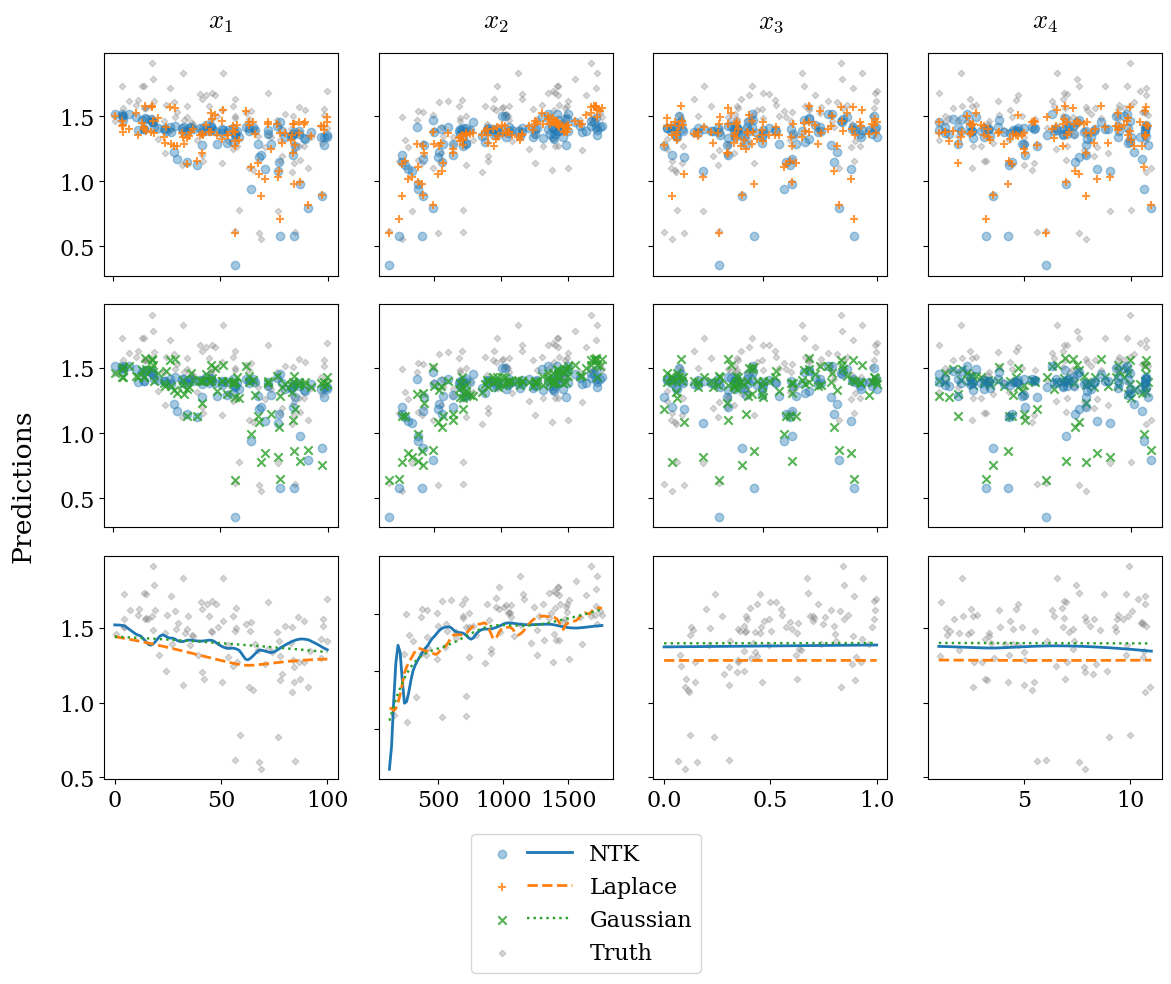

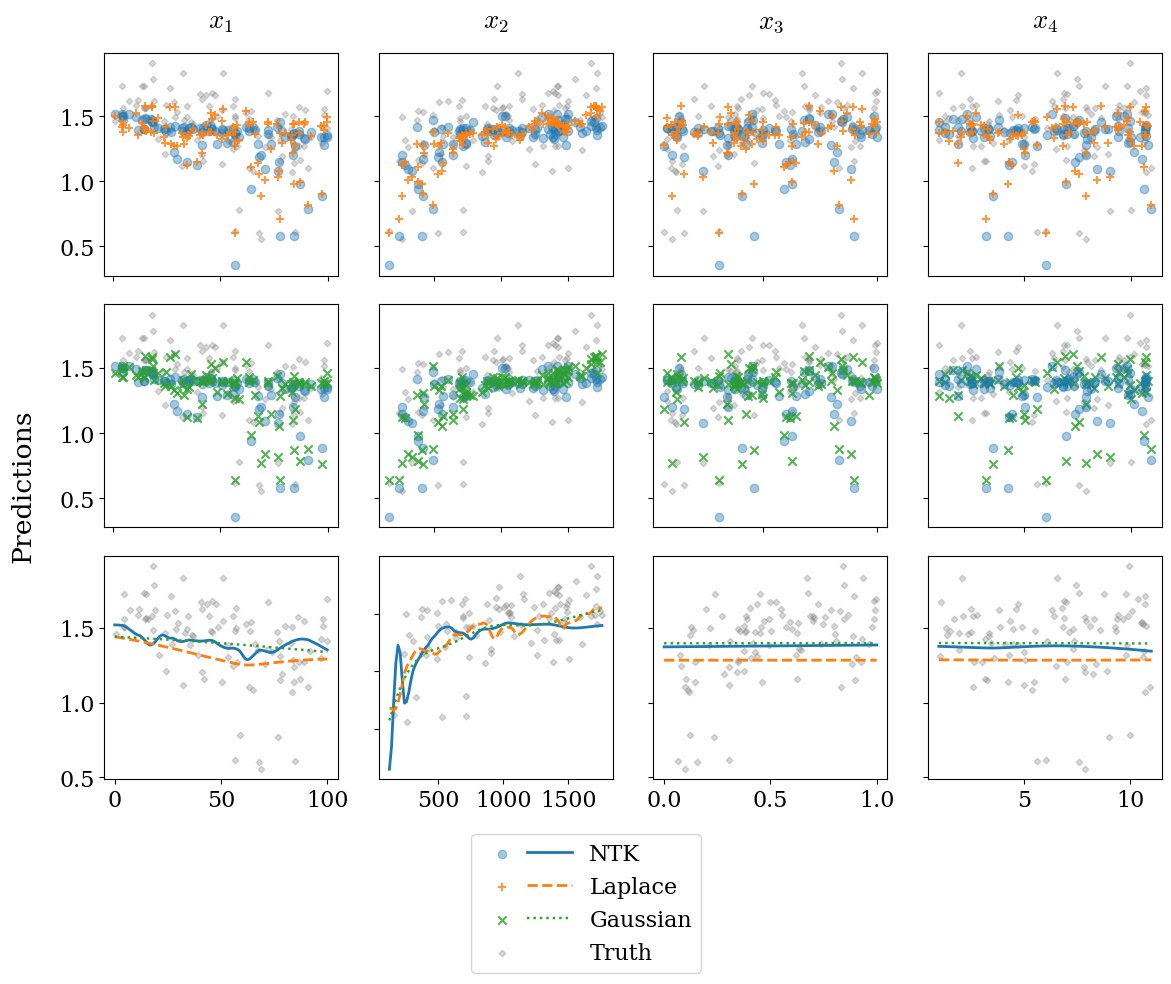

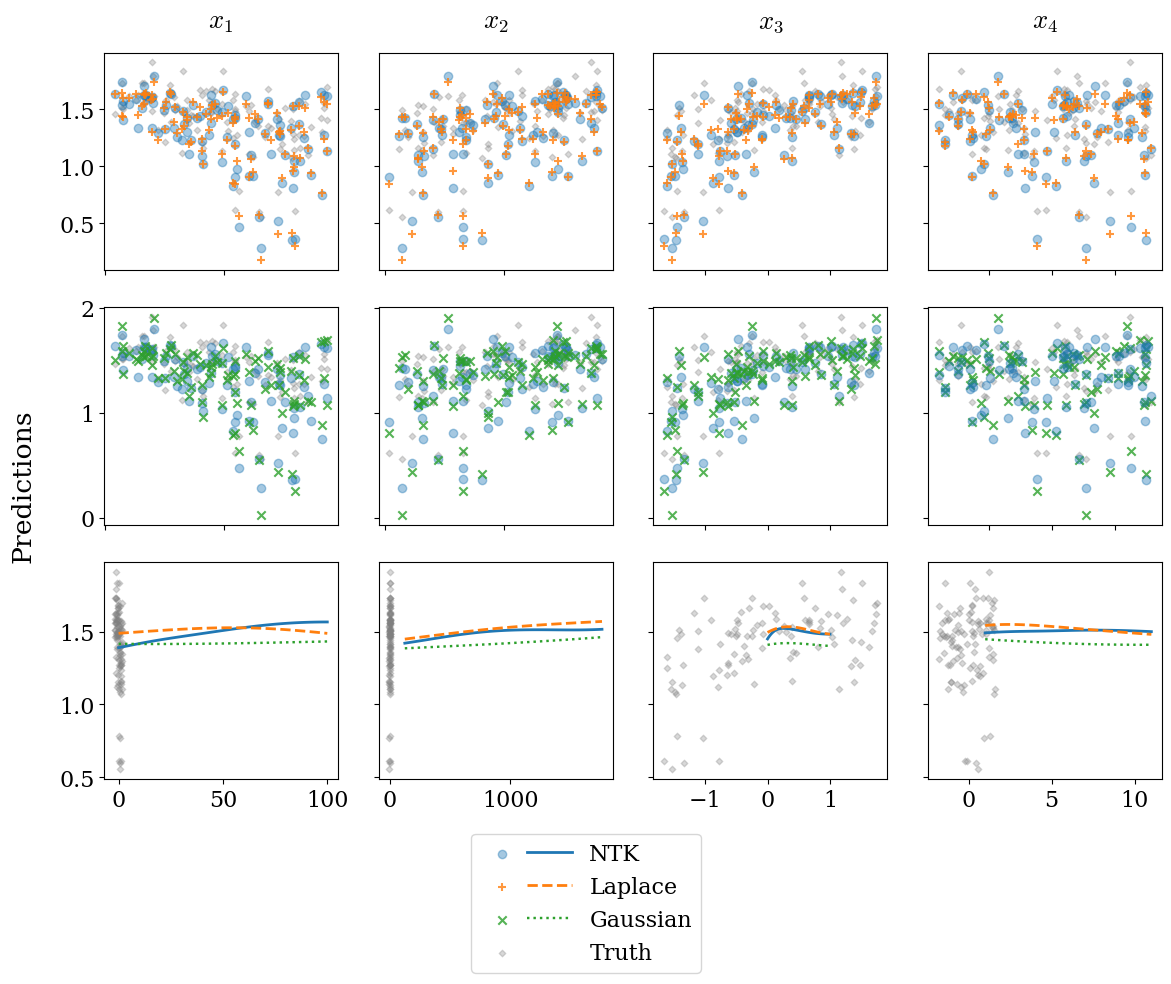

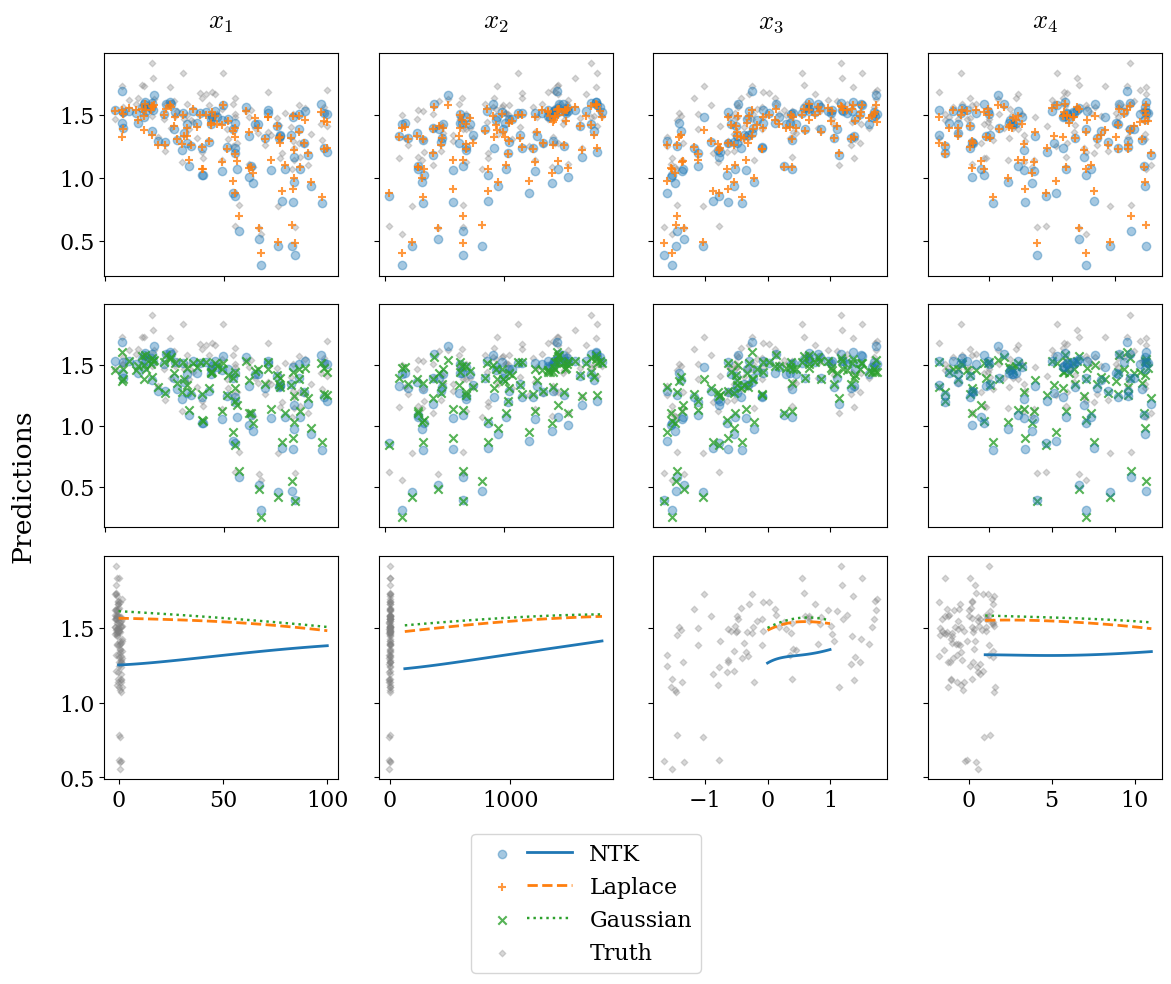

In [41]:
# F2 Sd outputs rescaled
# F2 Rd outputs rescaled
# F3 Sd inputs rescaled
# F3 Rd inputs rescaled
# 
# F3 Sd noisy   - 33
# F3 Sd         - 30
# F2 Sd         - 18
# F2 Sd noisy   - 21
pos = 27
data = True
make_plot('none', pos)
make_plot('norm_y', pos)
fig, _ = make_plot('rescale', pos, data)
make_plot('norm_y_rescale', pos, data)

In [ ]:
fig.savefig("./exp/highD/F3D2Rdrescale.svg")

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12,3), sharey=True)
axes=axes.ravel()

plotting_X = experiment_output[pos]['dataset']['draw']
mean_lap = experiment_output[pos]['means'][1]
mean_gaus = experiment_output[pos]['means'][2]
mean_ntk = experiment_output[pos]['means'][0]
ground = experiment_output[pos]['dataset']['test'][1]

for i in range(0,4):
    if data:
        axes[i].scatter(plotting_X[:,i], ground, s=15, marker='x', c='black', alpha=1)